In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [119]:

f_ttree =  "/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-1000_MY-600_TuneCP5_13TeV-madgraph-pythia8/ntuple.root"
f_ranker = "/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/weaver-multiH/weaver/models/exp_xy/feynnet_6b/20230407_ranger_lr0.0047_batch1024_/predict_output/NMSSM_XToYHTo6B_MX-1000_MY-600_TuneCP5_13TeV-madgraph-pythia8.root_4b.awkd"

In [106]:

f_ttree = "/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag_4b/Official_NMSSM/NMSSM_XToYHTo6B_MX-600_MY-250_TuneCP5_13TeV-madgraph-pythia8/ntuple.root"
f_ranker = "/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/weaver-multiH/weaver/models/exp_xy/feynnet_6b/20230407_ranger_lr0.0047_batch1024_/predict_output/NMSSM_XToYHTo6B_MX-600_MY-250_TuneCP5_13TeV-madgraph-pythia8.root_4b.awkd"

In [120]:
tree = Tree(f_ttree)

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


In [108]:
sixb_mask = tree.nfound_select == 6

In [138]:
import awkward0 as ak0

def get_reco_id(tree, f_ranker):
    with ak0.load(f_ranker) as ranker:
        jet_comb = ak.from_regular(ranker['maxcomb'].astype(int))
        reco_label = ak.from_regular(ranker['maxlabel'])

    j_p4 = build_p4(tree, 'jet', extra=['signalId'])
    j1_p4, j2_p4 = j_p4[jet_comb[:,::2]], j_p4[jet_comb[:,1::2]]
    h_p4 = j1_p4 + j2_p4
    j1_h_id = j1_p4.signalId // 2
    j2_h_id = j2_p4.signalId // 2
    h_id = ak.where( j1_h_id == j2_h_id, j1_h_id, -1)

    hx_p4 = h_p4[:,0]
    hx_id = h_id[:,0] == 0
    hy_p4 = h_p4[:,1:]
    hy_id = h_id[:,1:]
    
    # hx_p4 = h_p4[:,2]
    # hx_id = h_id[:,2] == 0
    # hy_p4 = h_p4[:,:2]
    # hy_id = h_id[:,:2]

    # hx_p4 = h_p4[:,1]
    # hx_id = h_id[:,1] == 0
    # hy_p4 = h_p4[:,[0,2]]
    # hy_id = h_id[:,[0,2]]


    y_p4 = hy_p4[:,0] + hy_p4[:,1]
    hy_y_id = ((hy_id+1)//2) == 1

    y_id = 1*(hy_y_id[:,0] & hy_y_id[:,1])
    reco_id = y_id & hx_id

    hy_m = hy_p4.m[ ak.argsort(hy_p4.pt, axis=1, ascending=False) ]

    tree.extend(
        reco_label=reco_label,
        reco_id=reco_id,
        n_reco_h=ak.sum(h_id>-1,axis=1),
        h_id=h_id,
        HX_m=hx_p4.m,
        H1_m=hy_m[:,0],
        H2_m=hy_m[:,1],
        Y_m=y_p4.m,
    )

    return reco_id

In [139]:
reco_id = get_reco_id(tree, f_ranker)

In [140]:
sixb_tree = EventFilter('sixb_tree',filter=lambda t : t.nfound_select==6)(tree)

100%|██████████| 1/1 [00:00<00:00, 15.51it/s]


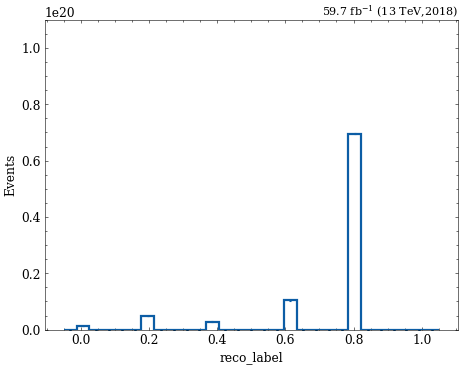

In [141]:
study.quick(
    [sixb_tree],
    varlist=['reco_label'],
    binlist=[(-0.05,1.05,30)]
)

In [142]:
ak.mean(sixb_tree.reco_id)

0.11731721922804725

In [143]:
varinfo.Y_m = dict(bins=(0,1000,30))
varinfo.HX_m = dict(bins=(0,300,30))
varinfo.H1_m = dict(bins=(0,300,30))
varinfo.H2_m = dict(bins=(0,300,30))


100%|██████████| 6/6 [00:00<00:00, 19.54it/s]


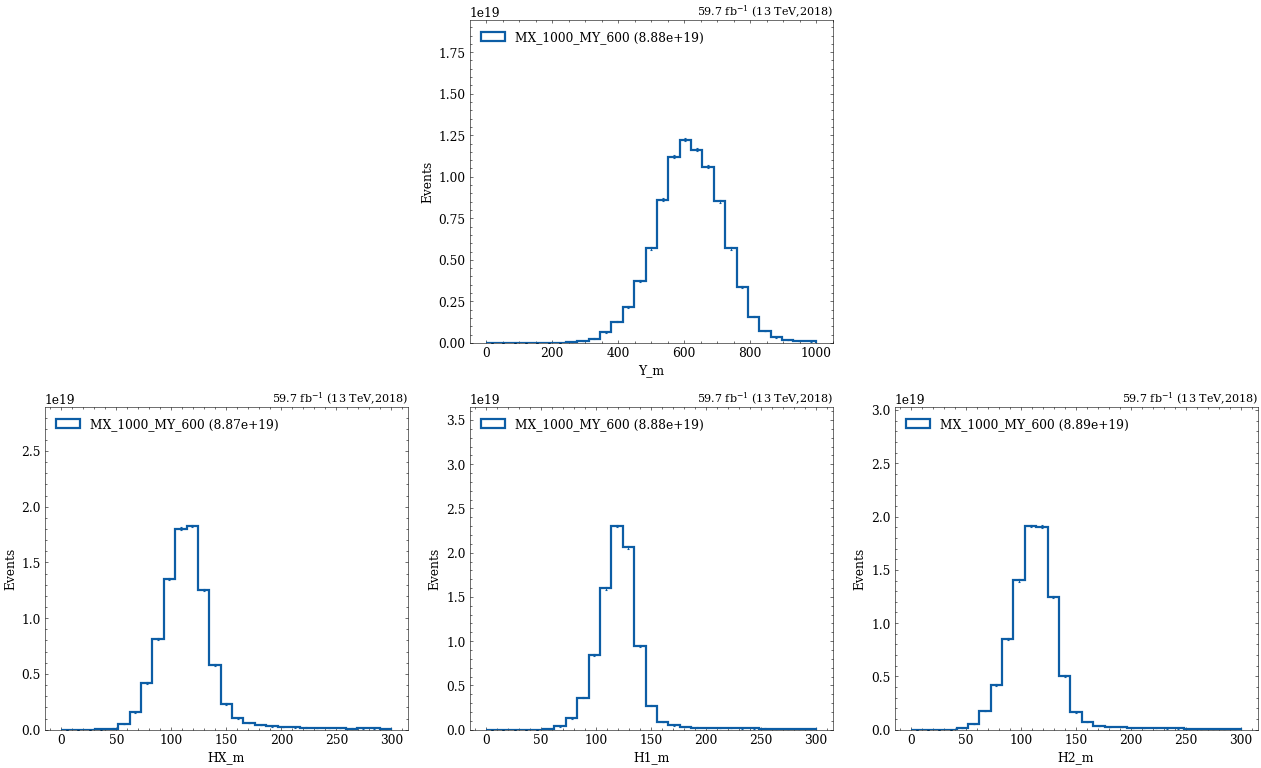

In [144]:
study.quick(
    [tree],
    masks=lambda t : t.nfound_select==6,
    varlist=[None,'Y_m',None,'HX_m','H1_m','H2_m'],
    legend=True,
)

100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


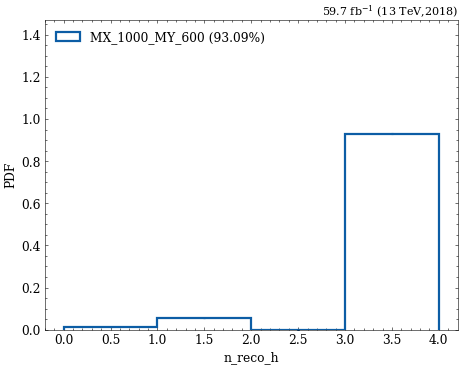

In [145]:
study.quick(
    [tree],
    masks=lambda t : t.nfound_select==6,
    varlist=['n_reco_h'],
    legend=True,
    efficiency=True,
    h_label_stat=lambda h:f'{h.histo[-1]:0.2%}',
)